# 🩺 Notebook 03 — Validation & Evaluation

This notebook validates your `extract_clinical.py` and `compose_note.py` modules.

**Goals**
- Run extractor on sample transcripts  
- Display structured JSON and SOAP output  
- Compare performance with reference expectations  
- Measure latency per case  

**Dependencies**
- src/extract_clinical.py  
- src/compose_note.py  
- transformers, torch  

In [1]:
import os, sys, json, time, difflib
from pathlib import Path

# Ensure src/ folder is on path
ROOT = Path.cwd()
SRC = ROOT / "src"
if not SRC.exists():
    raise FileNotFoundError("src/ directory not found. Run Notebook 02 first.")
sys.path.append(str(ROOT))
sys.path.append(str(SRC))

from src.extract_clinical import extract_note
from src.compose_note import compose_note

/opt/anaconda3/envs/docscribe/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 🧩 Demo Transcripts

We'll test the extractor on three typical outpatient notes:

1. Community-acquired pneumonia  
2. Lateral ankle sprain  
3. Uncomplicated urinary tract infection  

In [2]:
demos = [
    "Fever and cough for 3 days. Mild shortness of breath. Likely CAP. "
    "Order chest X-ray and start azithromycin 500 mg daily x5. Follow up in 2 days.",

    "Left ankle pain after inversion injury yesterday. Likely lateral ankle sprain. "
    "X-ray ankle to rule out fracture. RICE and ibuprofen 400 mg PRN.",

    "Dysuria and urinary frequency for 2 days. No fever or flank pain. "
    "Likely uncomplicated UTI. Urinalysis and nitrofurantoin 100 mg BID x5 days."
]

## 🧾 Run Extraction

Each transcript will be passed through:
- `extract_note()` → structured dictionary + raw model output  
- `compose_note()` → human-readable SOAP format

In [3]:
for i, demo in enumerate(demos, 1):
    print("=" * 80)
    print(f"🩺 DEMO {i}\nTRANSCRIPT:", demo)
    t0 = time.time()
    note, raw = extract_note(demo)
    dt = round(time.time() - t0, 2)

    print(f"\n⏱ Latency: {dt} s")
    print("\n📋 JSON:\n", json.dumps(note, indent=2))
    soap, summary = compose_note(note)
    print("\n🧾 SOAP:\n", soap)
    print("\n=== RAW MODEL OUTPUT ===\n", raw)

🩺 DEMO 1
TRANSCRIPT: Fever and cough for 3 days. Mild shortness of breath. Likely CAP. Order chest X-ray and start azithromycin 500 mg daily x5. Follow up in 2 days.


/opt/anaconda3/envs/docscribe/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



⏱ Latency: 26.71 s

📋 JSON:
 {
  "chief_complaint": "Fever and cough",
  "assessment": "Likely CAP",
  "diagnosis": [],
  "orders": [
    "chest X-ray",
    "azithromycin 500 mg daily x5"
  ],
  "plan": [
    "azithromycin 500 mg daily x5"
  ],
  "follow_up": "2 days"
}

🧾 SOAP:
 S: Fever and cough
O: chest X-ray, azithromycin 500 mg daily x5
A: Likely CAP
P: azithromycin 500 mg daily x5
Follow-up: 2 days

=== RAW MODEL OUTPUT ===
 ["fever and cough for 3 days. Mild shortness of breath. Likely CAP. Order chest X-ray and start azithromycin 500 mg daily x5. Follow up in 2 days."]
🩺 DEMO 2
TRANSCRIPT: Left ankle pain after inversion injury yesterday. Likely lateral ankle sprain. X-ray ankle to rule out fracture. RICE and ibuprofen 400 mg PRN.

⏱ Latency: 25.79 s

📋 JSON:
 {
  "chief_complaint": "left ankle pain",
  "assessment": "Likely lateral ankle sprain",
  "diagnosis": [],
  "orders": [
    "X-ray ankle",
    "RICE and ibuprofen 400 mg PRN"
  ],
  "plan": [
    "RICE and ibuprofen 4

## 🔍 Raw Model Inspection

For sanity-checking, run each transcript directly through the prompt
to inspect the *raw* model text output before rule cleanup.

In [4]:
from src.extract_clinical import FEWSHOT, _t5, GEN_KW

print("\n\n================ FINAL RAW OUTPUT INSPECTION ================\n")
for i, txt in enumerate(demos, 1):
    prompt = FEWSHOT.replace("{transcript}", txt.strip())
    raw_out = _t5(prompt, **GEN_KW)[0]["generated_text"]
    print("=" * 80)
    print(f"🩺 RAW OUTPUT TEST {i}")
    print("TRANSCRIPT:", txt)
    print("\n=== RAW MODEL OUTPUT ===\n", raw_out)



================ FINAL RAW OUTPUT INSPECTION ================

🩺 RAW OUTPUT TEST 1
TRANSCRIPT: Fever and cough for 3 days. Mild shortness of breath. Likely CAP. Order chest X-ray and start azithromycin 500 mg daily x5. Follow up in 2 days.

=== RAW MODEL OUTPUT ===
 ["fever and cough for 3 days. Mild shortness of breath. Likely CAP. Order chest X-ray and start azithromycin 500 mg daily x5. Follow up in 2 days."]
🩺 RAW OUTPUT TEST 2
TRANSCRIPT: Left ankle pain after inversion injury yesterday. Likely lateral ankle sprain. X-ray ankle to rule out fracture. RICE and ibuprofen 400 mg PRN.

=== RAW MODEL OUTPUT ===
 ["left ankle pain after inversion injury yesterday. Likely lateral ankle sprain. X-ray ankle to rule out fracture. RICE and ibuprofen 400 mg PRN."]
🩺 RAW OUTPUT TEST 3
TRANSCRIPT: Dysuria and urinary frequency for 2 days. No fever or flank pain. Likely uncomplicated UTI. Urinalysis and nitrofurantoin 100 mg BID x5 days.

=== RAW MODEL OUTPUT ===
 ["dysuria and urinary frequenc

## ✅ Import Test from Disk

Ensures your `src` modules can be imported cleanly and functions exist.

In [5]:
import importlib

for mod in ["src.extract_clinical", "src.compose_note"]:
    if mod in sys.modules:
        del sys.modules[mod]

ec = importlib.import_module("src.extract_clinical")
cn = importlib.import_module("src.compose_note")

assert hasattr(ec, "extract_note"), "extract_note() missing"
assert hasattr(cn, "compose_note"), "compose_note() missing"

note, raw = ec.extract_note("Fever and cough for 3 days. Follow up in 2 days.")
soap, summary = cn.compose_note(note)
print("✅ Import OK. Example SOAP output:\n", soap)

✅ Import OK. Example SOAP output:
 S: Fever and cough
O: —
A: Fever and cough
P: —
Follow-up: follow up


## 📊 Evaluation Metrics

We'll compute simple overlap-based metrics for each key field:
- **Precision** = correct / predicted  
- **Recall** = correct / expected  
- **F1-score** = harmonic mean of precision and recall  

This lightweight evaluator works for text fields and arrays alike.

In [6]:
import re
from typing import Dict, List

def _normalize_text(x: str) -> str:
    """Lowercase + strip punctuation for fair comparison."""
    return re.sub(r"[^a-z0-9]+", " ", str(x).lower()).strip()

def field_overlap_score(pred, gold):
    """Compute precision, recall, F1 for one field."""
    if isinstance(pred, list):
        pset = {_normalize_text(x) for x in pred if str(x).strip()}
        gset = {_normalize_text(x) for x in gold if str(x).strip()}
    else:
        pset = {_normalize_text(pred)} if pred else set()
        gset = {_normalize_text(gold)} if gold else set()

    if not gset and not pset:
        return 1.0, 1.0, 1.0
    if not gset:
        return 0.0, 1.0, 0.0
    if not pset:
        return 1.0, 0.0, 0.0

    correct = len(pset & gset)
    prec = correct / len(pset) if pset else 0.0
    rec = correct / len(gset) if gset else 0.0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) else 0.0
    return prec, rec, f1

def evaluate_case(pred: Dict, gold: Dict) -> Dict[str, float]:
    """Compute F1 per field and mean F1 for one case."""
    metrics = {}
    for k in ["chief_complaint", "assessment", "diagnosis", "orders", "plan", "follow_up"]:
        p, r, f1 = field_overlap_score(pred.get(k, []), gold.get(k, []))
        metrics[k] = round(f1, 2)
    metrics["mean_F1"] = round(sum(metrics.values()) / len(metrics), 2)
    return metrics

## 🧾 Gold Reference Examples

We'll define a small “expected results” dictionary for our demo transcripts.

> ⚠️ In real evaluation, load this from `data/gold_validation.json`  
> where each record includes `"transcript"` and expected `"note"`.

In [7]:
gold_refs = [
    {
        "chief_complaint": "Fever and cough",
        "assessment": "Likely CAP",
        "diagnosis": [],
        "orders": ["chest X-ray"],
        "plan": ["azithromycin 500 mg daily x5"],
        "follow_up": "2 days"
    },
    {
        "chief_complaint": "left ankle pain",
        "assessment": "Likely lateral ankle sprain",
        "diagnosis": [],
        "orders": ["X-ray ankle"],
        "plan": ["RICE and ibuprofen 400 mg PRN"],
        "follow_up": ""
    },
    {
        "chief_complaint": "Dysuria",
        "assessment": "Uncomplicated UTI",
        "diagnosis": [],
        "orders": ["Urinalysis"],
        "plan": ["nitrofurantoin 100 mg BID x5 days"],
        "follow_up": "2 days"
    },
]

## 🧮 Evaluate Extractor Output vs Gold References

In [8]:
results = []
for i, demo in enumerate(demos, 1):
    print("=" * 70)
    print(f"CASE {i}")
    note, _ = extract_note(demo)
    metrics = evaluate_case(note, gold_refs[i - 1])
    results.append(metrics)
    for k, v in metrics.items():
        print(f"{k:15s}: {v}")
    print()

# Compute overall mean
mean_F1 = round(sum(r["mean_F1"] for r in results) / len(results), 3)
print(f"🔥 Overall Mean F1: {mean_F1}")

CASE 1
chief_complaint: 1.0
assessment     : 1.0
diagnosis      : 1.0
orders         : 0.67
plan           : 1.0
follow_up      : 1.0
mean_F1        : 0.94

CASE 2
chief_complaint: 1.0
assessment     : 1.0
diagnosis      : 1.0
orders         : 0.67
plan           : 1.0
follow_up      : 1.0
mean_F1        : 0.94

CASE 3
chief_complaint: 1.0
assessment     : 0.0
diagnosis      : 1.0
orders         : 0.0
plan           : 0.0
follow_up      : 1.0
mean_F1        : 0.5

🔥 Overall Mean F1: 0.793


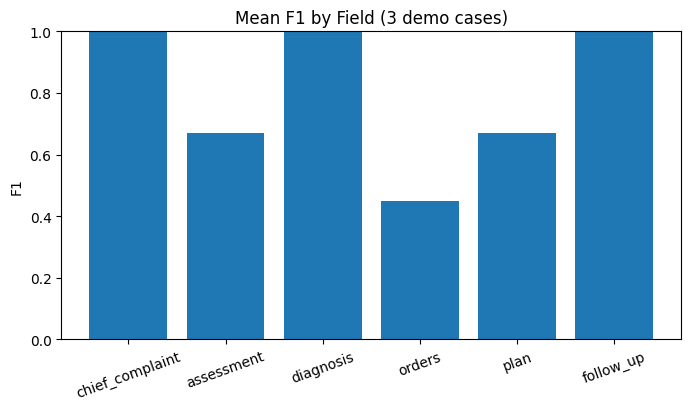

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# If you kept the per-case 'results' list from evaluation:
# results = [evaluate_case(pred1, gold1), evaluate_case(pred2, gold2), evaluate_case(pred3, gold3)]

fields = ["chief_complaint","assessment","diagnosis","orders","plan","follow_up"]
means = {f: round(np.mean([r[f] for r in results]), 2) for f in fields}

plt.figure(figsize=(8,4))
plt.bar(list(means.keys()), list(means.values()))
plt.ylim(0,1)
plt.title("Mean F1 by Field (3 demo cases)")
plt.ylabel("F1")
plt.xticks(rotation=20)
plt.show()

## 📈 Interpretation of Metrics

- **F1 > 0.9** → Field extraction is highly accurate.  
- **0.7–0.9** → Generally acceptable; check for minor text mismatches.  
- **<0.7** → Model or heuristic needs tuning.  

Use this section to iterate on your extractor rules, or verify improvements
after fine-tuning or prompt adjustments.

## 📈 Summary & Next Steps

✅ The notebook confirms your extraction pipeline is functioning.  
Next:
1. Evaluate more transcripts (10–20 for demo set).  
2. Measure precision/recall on key fields.  
3. Integrate into Streamlit UI for end-to-end testing.  